In [2]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import os
from os import sys, path
import glob
from skimage import io, transform

path='/home/debacwa/Software/CRFasRNNLayer'
if path not in sys.path:
    sys.path.append(os.path.abspath(path))

%load_ext autoreload
%autoreload 2


# Load data

In [3]:
im_fns = sorted(glob.glob('/data/dl-IMAGEDATA/StanfordBackGroundDataset/iccv09Data/images/*.jpg'))
labels_fns = sorted(glob.glob('/data/dl-IMAGEDATA/StanfordBackGroundDataset/iccv09Data/labels/*.regions.txt'))

im_fns = im_fns[:300]
labels_fns = labels_fns[:300]

def imread(path):
    from skimage import io, transform
    im = io.imread(path).astype(np.float32)
    im /= 255
    im = transform.resize(im, (240,320,3), order=1, mode='constant')
    return im

def readlabel(path, num_classes=8):
    im = np.loadtxt(path)
    im = transform.resize(im, (240,320), order=0, mode='constant').astype(np.uint8)
    # set unknown to background class 0
    im[ im == 255] = 0
    # convert to one-hot notation
    im = np.array([im==c for c in range(num_classes)]).astype(np.uint8)
    # move channels axis to last dimension
    im = np.moveaxis(im, 0, -1)
    return im

from joblib import Parallel, delayed
#X = np.array([imread(fn) for fn in im_fns])
X = np.array(Parallel(n_jobs=-1)(delayed(imread)(fn) for fn in im_fns))
X.shape
   
num_classes = 8
Y = np.array(Parallel(n_jobs=-1)(delayed(readlabel)(fn, num_classes) for fn in labels_fns))
Y.shape



(300, 240, 320, 8)

im_fns = sorted(glob.glob('/home/debacwa/Software/CRFasRNNLayer/ImageData/*img.tif'))
labels_fns = sorted(glob.glob('/home/debacwa/Software/CRFasRNNLayer/ImageData/*lab.tif'))

#print(im_fns)
#print(labels_fns)
#im_fns = im_fns[:100]
#labels_fns = labels_fns[:100]

from skimage import io, transform
from skimage.external import tifffile

def imread(path):
    im = tifffile.imread(path).astype(np.float32)
    im /= 255.
    im = transform.resize(im, (240,320,3), order=1, mode='constant')
    return im

def readlabel(path, num_classes=8):
    #im = np.loadtxt(path)
    im = tifffile.imread(path).astype(np.uint8)
    #im = transform.resize(im, (240,320), order=0, mode='constant').astype(np.uint8)
    # set unknown to background class 0
    im[ im == 255] = 0
    # convert to one-hot notation
    #im = np.array([im==c for c in range(num_classes)]).astype(np.uint8)
    im_onehot = []
    for c in range(num_classes):
        #print('class ', c, 'pixels ', np.count_nonzero(im==c))
        im_onehot.append( np.array(im==c))
    im = np.array( im_onehot, dtype=np.uint8)
    # move channels axis to last dimension
    im = np.moveaxis(im, 0, -1)
    return im

from joblib import Parallel, delayed
X = np.array([imread(fn) for fn in im_fns])
#X = np.array(Parallel(n_jobs=-1)(delayed(imread)(fn) for fn in im_fns))
#X.shape
   
num_classes = 3
Y = np.array([readlabel(fn, num_classes) for fn in labels_fns])
#Y = np.array(Parallel(n_jobs=-1)(delayed(readlabel)(fn, num_classes) for fn in labels_fns))
Y.shape



## Show a few samples

In [4]:
def print_samples(x, y, indices, gt=None):
    nc = 2
    if gt is not None:
        nc += 1
        assert x.shape[:2] == gt.shape[:2]
    n = len(indices)
    
    fig, ax = plt.subplots(n, nc, figsize=(7,3*n))
    for i, sample in enumerate(indices):
        ax[i, 0].imshow( x[sample] )
        ax[i, 1].imshow( np.argmax(y[sample], axis=-1), vmin=0, vmax=num_classes, cmap='jet')
        if gt is not None:
            ax[i, 2].imshow( np.argmax(gt[sample], axis=-1), vmin=0, vmax=num_classes, cmap='jet')
    for a in ax.flat: a.axis('off')


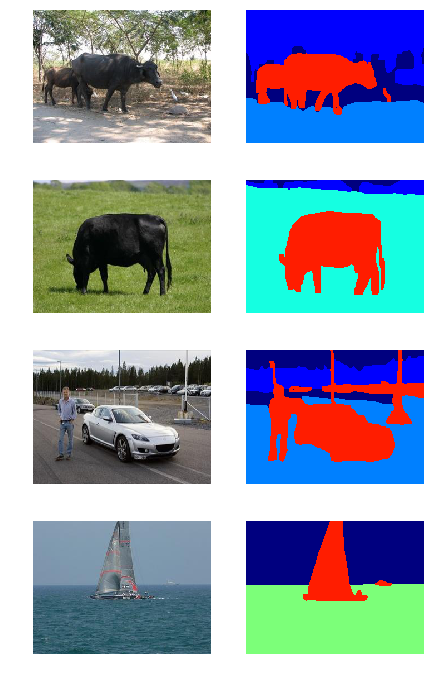

In [5]:
n=4
samples=np.random.randint( len(X), size=n)
print_samples(X, Y, samples)


In [6]:
Y.shape[-1]

8

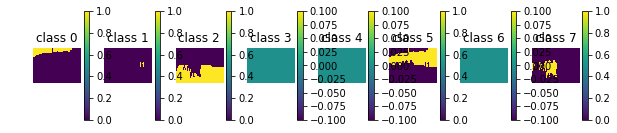

In [8]:
def print_onehot(y, index):
    fig, ax = plt.subplots(1,y.shape[-1], figsize=(10,10))

    for i, c in enumerate(range(y.shape[-1])):
        cax = ax[i].imshow(y[index,...,i])
        ax[i].set_title('class {}'.format(i))
        plt.colorbar(cax, ax=ax[i], shrink=0.2)
    for a in ax.flat: a.axis('off')
    plt.show()
    
print_onehot(Y, 0)

In [9]:
def array_props(a):
    print('Shape: {}\nMin:   {}\nMax:   {}\nMean:  {}'.format(a.shape, a.min(), a.max(), a.mean()))

In [10]:
print('-- X --'); array_props(X)
print('-- Y --'); array_props(Y)

-- X --
Shape: (300, 240, 320, 3)
Min:   0.0
Max:   1.0
Mean:  0.4860516210979934
-- Y --
Shape: (300, 240, 320, 8)
Min:   0
Max:   1
Mean:  0.125


## Split train and test set

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.10, random_state=42)

print('-- X_train --'); array_props(X_train)
print('-- Y_train --'); array_props(Y_train)

print('-- X_test --'); array_props(X_test)
print('-- Y_test --'); array_props(Y_test)

-- X_train --
Shape: (270, 240, 320, 3)
Min:   0.0
Max:   1.0
Mean:  0.4851702106228324
-- Y_train --
Shape: (270, 240, 320, 8)
Min:   0
Max:   1
Mean:  0.125
-- X_test --
Shape: (30, 240, 320, 3)
Min:   0.0
Max:   1.0
Mean:  0.4939843153744563
-- Y_test --
Shape: (30, 240, 320, 8)
Min:   0
Max:   1
Mean:  0.125


# Define network

In [12]:
def compile_CRF_RNN_Layer(path, 
                          spatial_dims=2,       # number of dimensions
                          input_channels=2,     # number of classes
                          reference_channels=3): # RGB

    '''
    Compiles the CRF_RNN_Layer with the given configuration options.
    
    1. Reconfigures build.sh by search/replace configuration options using `sed`
    2. Compiles CRF_RNN_Layer by running `sh build.sh`
    
    '''
    def replace(old, new):
        config_file = os.path.join(path, 'build.sh')
        # replace only first occurence in file (note: requires GNU sed)
        cmd = "sed -i -e '0,/{}/s//{}/g' {}".format(old, new, config_file)
        os.system(cmd)
        #print(cmd)
        
    # set configuration variables (note the wildcards ".*")
    replace('SPATIAL_DIMS=.*', 
            'SPATIAL_DIMS={}'.format(spatial_dims))
    replace('INPUT_CHANNELS=.*', 
            'INPUT_CHANNELS={}'.format(input_channels))
    replace('REFERENCE_CHANNELS=.*', 
            'REFERENCE_CHANNELS={}'.format(reference_channels))
    
    # re-compile CRF_RNN_Layer
    print(path)
    cmd = 'cd {} && pwd && sh build.sh'.format(path)
    os.system(cmd)
    return True

compile_CRF_RNN_Layer(path=path, input_channels=num_classes)

/home/debacwa/Software/CRFasRNNLayer


True

In [13]:
batch_size = 5
models = []

dl_utils_path = '/home/debacwa/Work/'
if dl_utils_path not in sys.path:
    sys.path.append(os.path.abspath(dl_utils_path))
from dl_utils import networks

model = networks.UNet(batch_shape=(batch_size, 240, 320, 3),
                     n_output_channels=num_classes,
                     depth=4, 
                     max_filters=256)
models.append( model )


/home/debacwa/miniconda3/envs/dl/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Tensor("softmax_1/truediv:0", shape=(5, 240, 320, 8), dtype=float32)


In [19]:
def unet_with_crf(batch_shape):
    model = networks.UNet(batch_shape=batch_shape,
                         n_output_channels=num_classes,
                         depth=4, 
                         max_filters=256)

    unaries = model.layers[-3].output
    reference_image = model.layers[0].input
    theta_alpha = 8
    theta_beta = 0.125
    theta_gamma = 1
    num_iterations = 5

    from crf_rnn_layer import CRF_RNN_Layer
    crf = CRF_RNN_Layer(image_dims=batch_shape[1:],
                        num_classes=num_classes, 
                        theta_alpha=theta_alpha, 
                        theta_beta=theta_beta, 
                        theta_gamma=theta_gamma, 
                        num_iterations=num_iterations)([unaries, reference_image])

    from keras import layers, models
    output = layers.Softmax(axis=-1)(crf)
    return models.Model(inputs=[model.layers[0].input], outputs=[output])


model = unet_with_crf(batch_shape=(batch_size, 240, 320, 3))
models.append( model )


Tensor("softmax_4/truediv:0", shape=(5, 240, 320, 8), dtype=float32)


# Loss function

In [20]:
def dice_coefficient(y_true, y_pred):
    """
    A statistic used for comparing the similarity of two samples. Here binary segmentations.

    Args:
        y_true (numpy.array): the true segmentation
        y_pred (numpy.array): the predicted segmentation

    Returns:
        (float) returns a number from 0. to 1. measuring the similarity y_true and y_pred
    """
    import keras.backend as K 
    y_true_f=K.flatten(y_true)
    y_pred_f=K.flatten(y_pred)
    intersection=K.sum(y_true_f*y_pred_f)
    smooth=1.0
    return (2*intersection+smooth)/(K.sum(y_true_f)+K.sum(y_pred_f)+smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coefficient(y_true, y_pred)

def dice_coef_multiclass(num_classes, ignore_class=None):
    
    def dice_coef(y_true, y_pred):
        dice = 0
        for index in range(num_classes):
            if ignore_class is not None and index == ignore_class:
                continue
            dice += dice_coefficient(y_true[..., index], y_pred[..., index])
        return dice
    return dice_coef
    
def dice_loss_multiclass(num_classes, ignore_class=None):
    
    def loss(y_true, y_pred):
        dice = 0
        for index in range(num_classes):
            if ignore_class is not None and index == ignore_class:
                continue
            dice -= dice_coefficient(y_true[..., index], y_pred[..., index])
        return dice

    #def loss(y_true, y_pred):
    #    return dice_coef_multilabel(y_true, y_pred, num_classes, ignore_class)
    
    return loss
    

In [21]:
for model in models:
    #Adam(lr=0.0001)
    model.compile(optimizer='adam',#SGD(lr=0.002), 
                  loss=dice_loss_multiclass(num_classes=num_classes, ignore_class=None), #'categorical_crossentropy') #dice_loss_multiclass(num_classes=num_classes, ignore_class=None)) #'categorical_crossentropy', 
                  metrics=[dice_coef_multiclass(num_classes=num_classes, ignore_class=None)])

# Train

In [17]:
print('-- X_train --'); array_props(X_train)
print('-- Y_train --'); array_props(Y_train)


-- X_train --
Shape: (270, 240, 320, 3)
Min:   0.0
Max:   1.0
Mean:  0.4851702106228324
-- Y_train --
Shape: (270, 240, 320, 8)
Min:   0
Max:   1
Mean:  0.125


## Train UNet *without* CRF 

In [18]:
history = models[0].fit(X_train, Y_train, 
          batch_size=batch_size, # note: number of X_train and X_test must be divisible by batch_size 
          epochs=30,
          validation_data=(X_test, Y_test))

Train on 270 samples, validate on 30 samples
Epoch 1/30
270/270 [==============================] - 6s 24ms/step - loss: -1.0378 - dice_coef: 1.0378 - val_loss: -1.1778 - val_dice_coef: 1.1778
Epoch 2/30
270/270 [==============================] - 4s 14ms/step - loss: -1.1632 - dice_coef: 1.1632 - val_loss: -1.2084 - val_dice_coef: 1.2084
Epoch 3/30
270/270 [==============================] - 4s 14ms/step - loss: -1.2128 - dice_coef: 1.2128 - val_loss: -1.2340 - val_dice_coef: 1.2340
Epoch 4/30
270/270 [==============================] - 4s 14ms/step - loss: -1.2354 - dice_coef: 1.2354 - val_loss: -1.2488 - val_dice_coef: 1.2488
Epoch 5/30
270/270 [==============================] - 4s 14ms/step - loss: -1.3181 - dice_coef: 1.3181 - val_loss: -1.3327 - val_dice_coef: 1.3327
Epoch 6/30
270/270 [==============================] - 4s 14ms/step - loss: -1.3347 - dice_coef: 1.3347 - val_loss: -1.3516 - val_dice_coef: 1.3516
Epoch 7/30
270/270 [==============================] - 4s 14ms/step - loss

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/debacwa/miniconda3/envs/dl/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-18-37439b8e740e>", line 4, in <module>
    validation_data=(X_test, Y_test))
  File "/home/debacwa/miniconda3/envs/dl/lib/python3.6/site-packages/keras/engine/training.py", line 1042, in fit
    validation_steps=validation_steps)
  File "/home/debacwa/miniconda3/envs/dl/lib/python3.6/site-packages/keras/engine/training_arrays.py", line 199, in fit_loop
    outs = f(ins_batch)
  File "/home/debacwa/miniconda3/envs/dl/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 2661, in __call__
    return self._call(inputs)
  File "/home/debacwa/miniconda3/envs/dl/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 2631, in _call
    fetched = self._callable_fn(*array_vals)
  File "/home/debacwa/miniconda3/envs/dl/lib/pytho

KeyboardInterrupt: 

## Train UNet *with* CRF 

In [22]:
history = models[1].fit(X_train, Y_train, 
          batch_size=batch_size,
          epochs=50,
          validation_data=(X_test, Y_test))

Train on 270 samples, validate on 30 samples
Epoch 1/50
270/270 [==============================] - 11s 40ms/step - loss: -1.2509 - dice_coef: 1.2509 - val_loss: -1.7864 - val_dice_coef: 1.7864
Epoch 2/50
270/270 [==============================] - 9s 33ms/step - loss: -2.0282 - dice_coef: 2.0282 - val_loss: -2.3472 - val_dice_coef: 2.3472
Epoch 3/50
270/270 [==============================] - 9s 33ms/step - loss: -2.6985 - dice_coef: 2.6985 - val_loss: -2.7137 - val_dice_coef: 2.7137
Epoch 4/50
270/270 [==============================] - 9s 33ms/step - loss: -2.6616 - dice_coef: 2.6616 - val_loss: -2.5269 - val_dice_coef: 2.5269
Epoch 5/50
270/270 [==============================] - 9s 33ms/step - loss: -3.0272 - dice_coef: 3.0272 - val_loss: -2.8450 - val_dice_coef: 2.8450
Epoch 6/50
270/270 [==============================] - 9s 33ms/step - loss: -3.2366 - dice_coef: 3.2366 - val_loss: -3.0918 - val_dice_coef: 3.0918
Epoch 7/50
270/270 [==============================] - 9s 33ms/step - los

# Predict

In [23]:
array_props(X_train)

Shape: (270, 240, 320, 3)
Min:   0.0
Max:   1.0
Mean:  0.4851702106228324


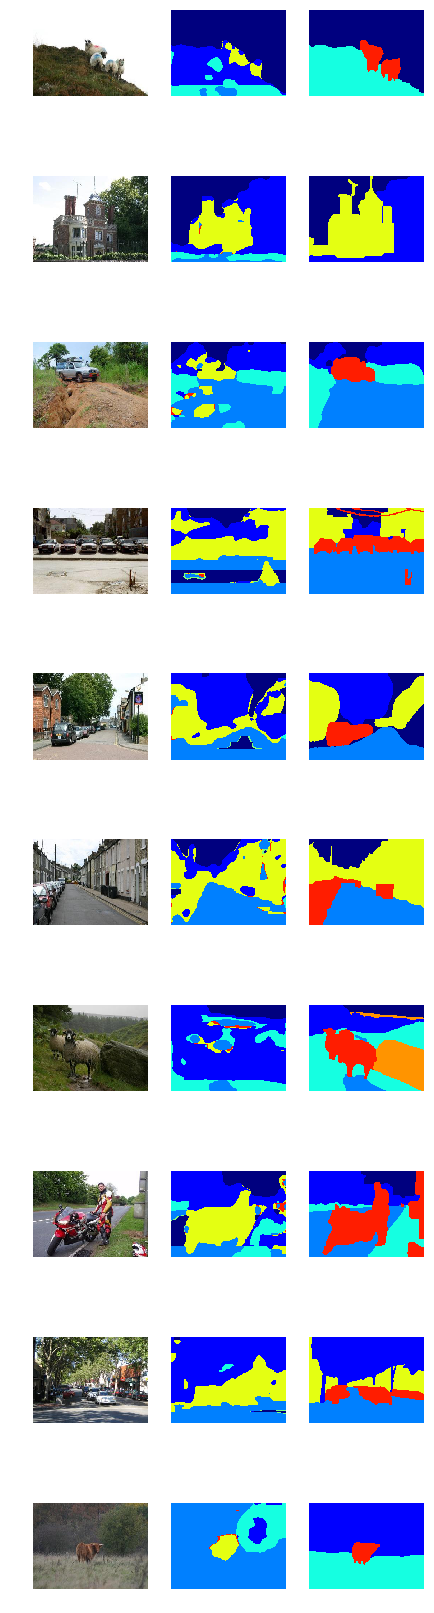

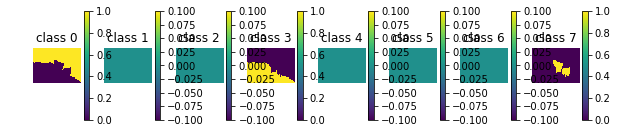

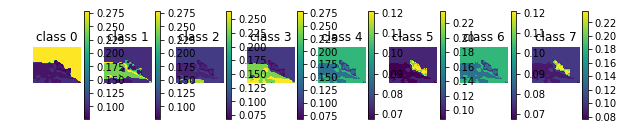

In [24]:
n = 10
result = models[0].predict(X_train[:n])
print_samples(X_train, result, range(n), gt=Y_train)

print_onehot(Y_train, 0)
print_onehot(result, 0)


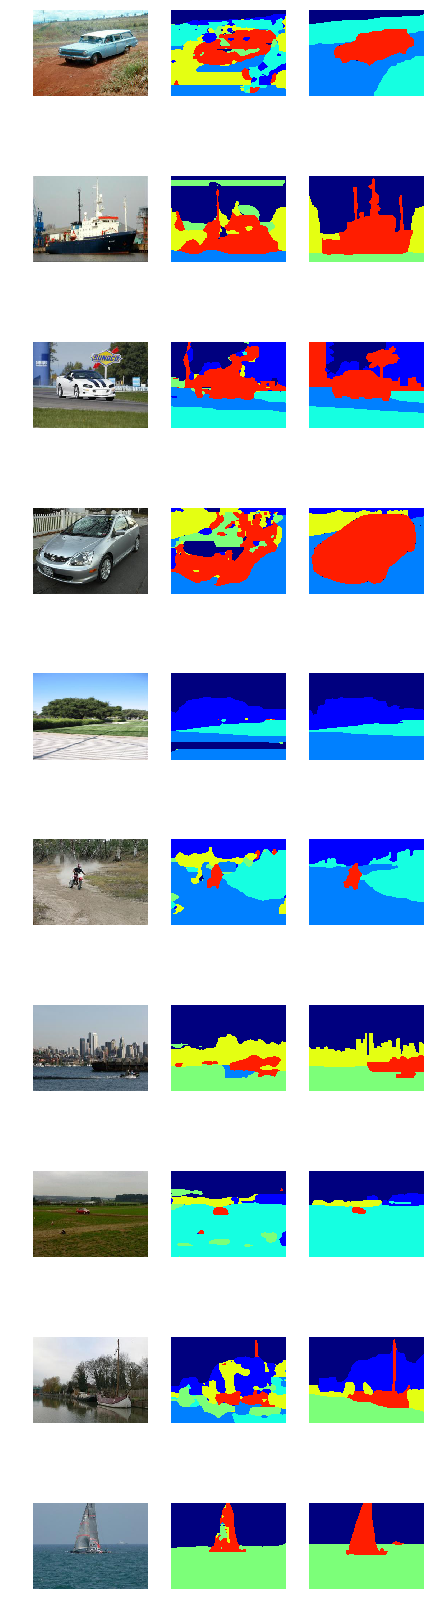

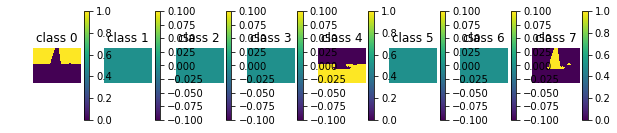

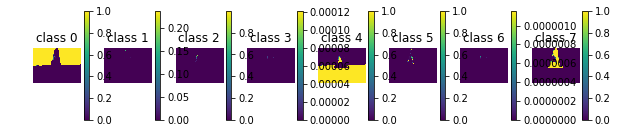

In [26]:
n = 10
result = models[1].predict(X_train[:n], batch_size=batch_size)
print_samples(X_train, result, range(n), gt=Y_train)

print_onehot(Y_train, 9)
print_onehot(result, 9)
